## Reading & Data Processing

In [1]:
# Projet: Classification des revus 
#Les différente packages utliser pour l'évolution du projet
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings; warnings.simplefilter('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import layers
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [0]:
# Tout d'abord Importation des données
df = pd.read_csv('irishtimes-date-text.csv')
#On ne veut que les mots avant le point , pour certain obesvation

df['category'] = df['headline_category'].apply(lambda x: x.split('.')[0])
# On recupére les valeur de notre data 
# dataset = df.values

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
cmap = plt.get_cmap("tab10") 
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2, perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx, elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   cmap = cmap(i),
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
    ax.legend(scatterpoints=1)
    fig.suptitle(my_name,
                 fontsize=10)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')

In [0]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [0]:
df.headline_text = df.headline_text.apply(lambda x : x.lower())
df['len_text'] = df.headline_text.apply(lambda x: len(x.split()))

In [0]:
df = df[df.len_text >= 5]

In [7]:
df.shape

(1191071, 5)

In [8]:
df.category.value_counts()

news         665156
sport        189972
business     175068
lifestyle     58361
culture       53309
opinion       49205
Name: category, dtype: int64

In [0]:
# La variable explicatif est headline_text
X = df.headline_text.iloc[0:500000].values

# La variable à expliquer category
Y = df.category.iloc[0:500000].values

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3,
                                                                    random_state=42, 
                                                                    stratify = Y)

#là nous avons juste de 2 sous échantillon
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, 
                                                Y_val_and_test,
                                                test_size=0.5, 
                                                random_state=42,
                                                stratify = Y_val_and_test)

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from sklearn.feature_extraction.text import TfidfVectorizer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
def tokenize(text) :
    tokens = word_tokenize(text)
    result = [lemmatizer.lemmatize(i) for i in tokens if (i.isalpha()) ] # & (i not in stop_words)) ]
    return ' '.join(result)

## paralellisation de la lemmatisation des textes
# from multiprocessing import Pool
# with Pool(4) as p: 
#     corpus_new = p.map(tokenize, X_train)
# with Pool(4) as p: 
#     corpus_val = p.map(tokenize, X_val)
# import tqdm
# corpus_new = []
# for elt in tqdm.tqdm(X_train) :
#     corpus_new.append(tokenize(elt))
# corpus_val = []
# for elt in tqdm.tqdm(X_train) :
#     corpus_val.append(tokenize(elt))
corpus_new = X_train
corpus_val = X_val


### TF-IDF des corpus

In [0]:
# !pip install nltk
# import nltk
# nltk.download('stopwords'); 
# nltk.download('punkt'); 
# nltk.download("wordnet")

#### Nombre et occurences des mots  

In [14]:
tmp = pd.Series(' '.join(corpus_new).split())
tmp.value_counts()

to                 91736
in                 66133
of                 59400
for                50999
the                39306
                   ...  
+web                   1
absinthe               1
porno                  1
cancer-research        1
tupac                  1
Length: 93187, dtype: int64

#### Distribution de le taille des phrases

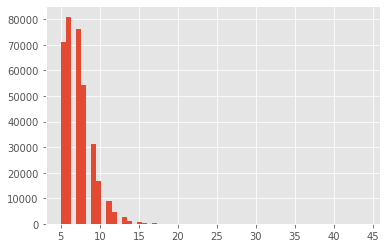

In [0]:
tmp = pd.Series([len(x.split()) for x in corpus_new])
tmp.hist(bins = 60)

#### LOGISTIC-REGRESSION + TF-IDF

In [0]:
vectorizer = TfidfVectorizer(decode_error='ignore',
                             smooth_idf=False, stop_words=stop_words,
                             encoding='utf-8', min_df = 3, max_df=12000)
corpus_idf = vectorizer.fit_transform(corpus_new)
corpus_idf.shape

(350000, 27513)

In [0]:
## LOGISTIC-REGRESSION + TF-IDF
from sklearn import linear_model
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import sklearn
logistic = linear_model.LogisticRegression()
C = np.logspace(-1, 1, 3)
params = dict(C=C, solver=['lbfgs'], max_iter=[1000], penalty=['l2'], multi_class=['auto'])
clf = GridSearchCV(logistic, params, cv=2, verbose=10,
                   n_jobs = 6,  scoring='accuracy')
clf = clf.fit(corpus_idf, Y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   47.1s remaining:  1.6min
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  1.3min remaining:   40.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.3min finished


In [0]:
y_pred_val = clf.predict(vectorizer.transform(corpus_val))
print('Accuracy on the training set : ',clf.score(corpus_idf, Y_train))
print("Accuracy on the validation set :", accuracy_score(Y_val, y_pred_val))

Accuracy on the training set :  0.81044
Accuracy on the validation set : 0.7818


## Embedding + LSTM + Classification

In [0]:
from keras import backend as K
import tensorflow as tf
def _get_available_gpus():  

    if K.tensorflow_backend._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        K.tensorflow_backend._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in K.tensorflow_backend._LOCAL_DEVICES if 'device:gpu' in x.lower()]


K.tensorflow_backend._get_available_gpus = _get_available_gpus

In [19]:
print(K.tensorflow_backend._get_available_gpus())
Y_train_ = pd.get_dummies(Y_train).values
Y_val_ = pd.get_dummies(Y_val).values

['/device:GPU:0']


### Tokenization et modèle

In [0]:
# Tout d'abord en encode la variable X par la méthode  Word Embeddings
tokenizer = Tokenizer(num_words=94000)
tokenizer.fit_on_texts(corpus_new)

X_train = tokenizer.texts_to_sequences(corpus_new)
X_val = tokenizer.texts_to_sequences(corpus_val)
# X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 10
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from keras.layers import Embedding, LSTM, Bidirectional
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
input_dim = X_train.shape[1]

embedding_dim = 64
n_classes = 6

In [49]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
bs = 1024
n_epochs = 5
history = model.fit(X_train, Y_train_, batch_size=bs, 
                    epochs=n_epochs, validation_data=(X_val, Y_val_))

Train on 350000 samples, validate on 75000 samples
Epoch 1/5
350000/350000 [==============================] - 39s 113us/step - loss: 0.8755 - accuracy: 0.7099 - val_loss: 0.6331 - val_accuracy: 0.7775
Epoch 2/5
350000/350000 [==============================] - 38s 109us/step - loss: 0.5937 - accuracy: 0.7885 - val_loss: 0.5913 - val_accuracy: 0.7859
Epoch 3/5
350000/350000 [==============================] - 38s 108us/step - loss: 0.5142 - accuracy: 0.8114 - val_loss: 0.5830 - val_accuracy: 0.7890
Epoch 4/5
350000/350000 [==============================] - 38s 109us/step - loss: 0.4690 - accuracy: 0.8271 - val_loss: 0.5885 - val_accuracy: 0.7912
Epoch 5/5
350000/350000 [==============================] - 38s 109us/step - loss: 0.4318 - accuracy: 0.8394 - val_loss: 0.6042 - val_accuracy: 0.7931


Training Accuracy: 0.8835
Validation Accuracy:  0.7903


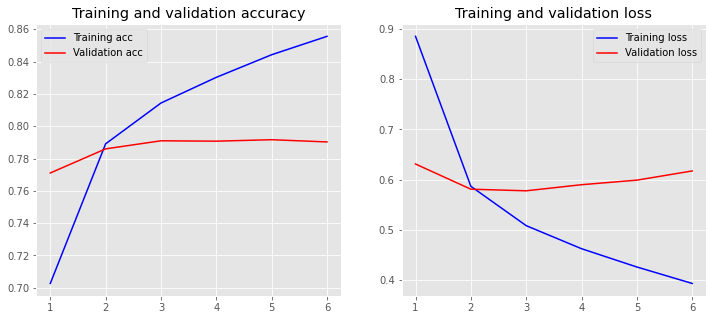

In [41]:
loss, accuracy = model.evaluate(X_train, Y_train_, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, Y_val_, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
_, x, _, y_ind = train_test_split(X_val, Y_val,
                                test_size=0.08, 
                                random_state=42,
                                stratify = Y_val)

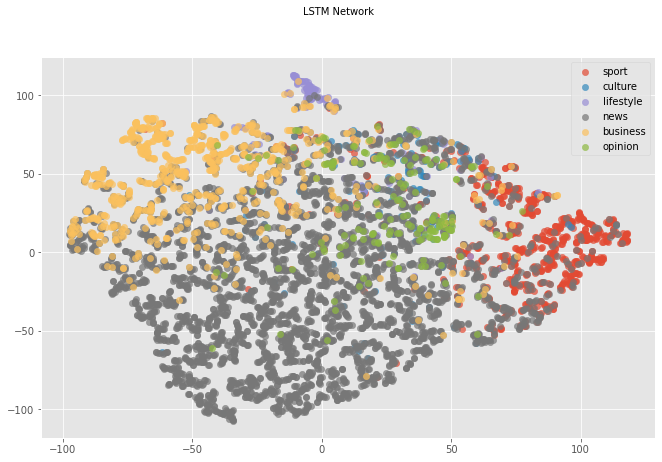

In [50]:
from keras import backend as K
get_doc_embedding = K.function([model.layers[0].input, K.learning_phase()],
                                [model.layers[-2].output])
doc_embs = get_doc_embedding([x, 0])[0]
visualize_doc_embeddings(doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan'], 
                         y_ind, 'LSTM Network')

### Saliency map 

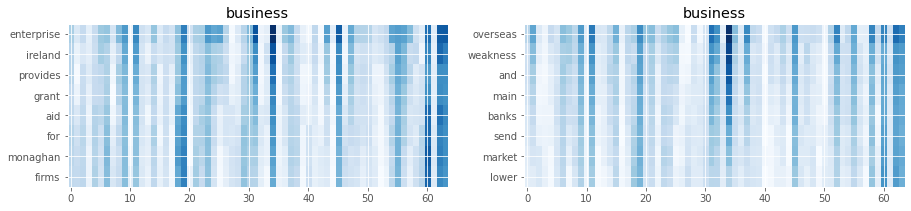

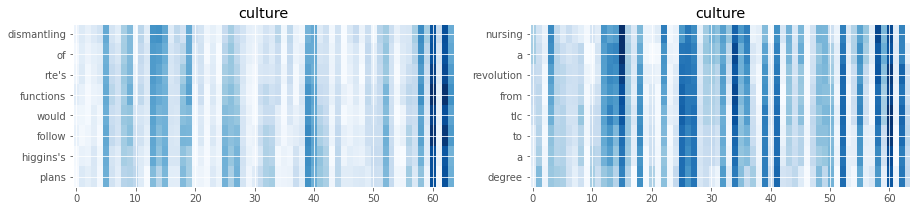

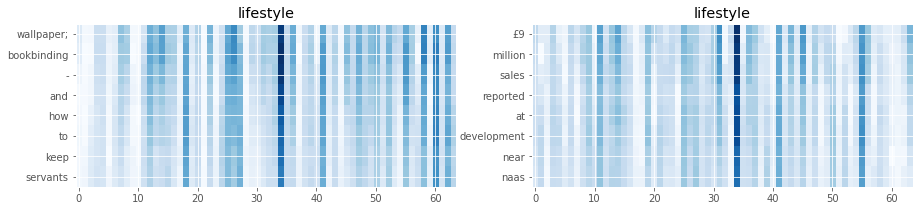

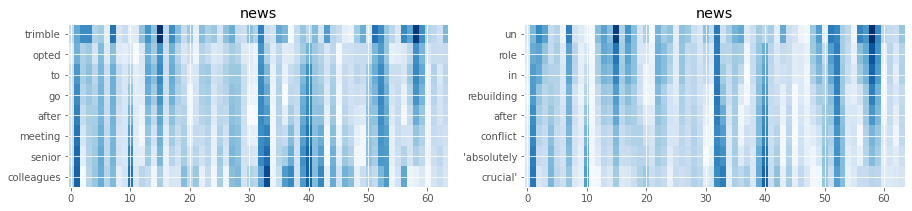

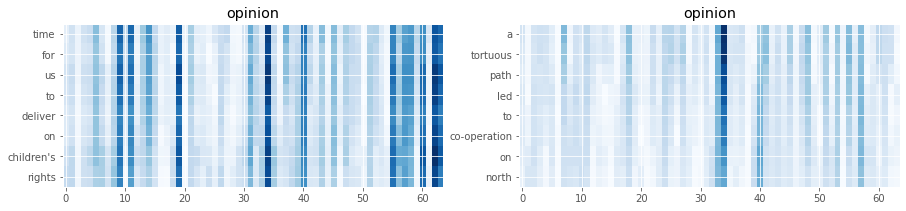

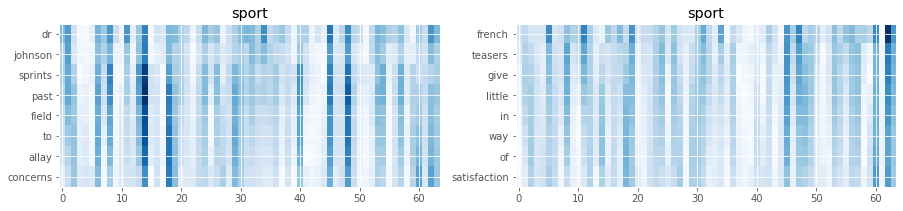

In [52]:
import warnings
warnings.simplefilter('ignore')
np.random.seed(0)
max_sent = 8
lenght = np.array([len(elt.split()) for elt in corpus_new])
for ind, element in enumerate(np.unique(Y_train)):
    index = np.random.choice(np.where((Y_train == element) & (lenght == max_sent))[0], 2)
    tokens = [corpus_new[i].split()[:max_sent] for i in index]
    tokens_ = X_train[index].reshape(2, maxlen)
#     y = Y_train[index]

    input_tensors = [model.layers[0].input, K.learning_phase()]
    saliency_input = model.layers[0].output ### fill the gap (extract the rows of the embedding matrix from the model) ###
    saliency_output = model.layers[-1].output[:, ind] ### fill the gap (get the probability distribution over classes from the model) ###

    gradients = model.optimizer.get_gradients(saliency_output, saliency_input)

    compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    matrix = compute_gradients([tokens_, 0])[0]

    ### fill the gap (compute the magnitude of the partial derivatives) ###
    ### you may use np.absolute https://docs.scipy.org/doc/numpy/reference/generated/numpy.absolute.html ###
    to_plot = np.absolute(matrix)

    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    for i in range(2):
        heatmap = ax[i].imshow(to_plot[i][:max_sent, :], cmap=plt.cm.Blues,interpolation='nearest', aspect='auto')
        ax[i].set_yticks(np.arange(len(tokens[i]))[:max_sent])
        ax[i].set_yticklabels(tokens[i][:max_sent])
        ax[i].tick_params(axis='y', which='major',labelsize=10 )
        ax[i].set_title(element)
#         ax[i].axis('off')
#     fig.colorbar(heatmap)
#     fig.set_size_inches(11,7)
    fig.savefig('LSTM_'+element + '_saliency_map.png', bbox_inches='tight')
    fig.show()

## Embedding + CNN

In [44]:
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Dense
from keras.models import Model
def cnn_branch(n_filters, k_size, d_rate, my_input):
    
    conv_layer = Conv1D(n_filters, k_size, activation='relu')(my_input)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    
    return Dropout(d_rate)(pool_layer)

nb_branches = 3
nb_filters = 80
filter_sizes = [2, 3, 4]
drop_rate = 0.2 # amount of dropout regularization
doc_ints = Input(shape=(None,))

doc_wv = Embedding(vocab_size, embedding_dim, input_length = maxlen)(doc_ints) 
doc_wv_dr = Dropout(drop_rate)(doc_wv)
branch_outputs = []
for idx in range(nb_branches):
    my_input = doc_wv_dr
    branch_outputs.append(cnn_branch(nb_filters, filter_sizes[idx], 
                                     drop_rate, my_input))
concat = Concatenate()(branch_outputs)

preds = Dense(n_classes, activation='softmax')(concat)
model = Model(doc_ints, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
bs = 2048
n_epochs = 4
history = model.fit(X_train, Y_train_, batch_size=bs, 
                    epochs=n_epochs, validation_data=(X_val, Y_val_))

Train on 350000 samples, validate on 75000 samples
Epoch 1/4
350000/350000 [==============================] - 6s 16us/step - loss: 0.9588 - accuracy: 0.6896 - val_loss: 0.6740 - val_accuracy: 0.7657
Epoch 2/4
350000/350000 [==============================] - 5s 13us/step - loss: 0.6024 - accuracy: 0.7872 - val_loss: 0.5870 - val_accuracy: 0.7865
Epoch 3/4
350000/350000 [==============================] - 4s 13us/step - loss: 0.5127 - accuracy: 0.8144 - val_loss: 0.5727 - val_accuracy: 0.7910
Epoch 4/4
350000/350000 [==============================] - 4s 13us/step - loss: 0.4553 - accuracy: 0.8338 - val_loss: 0.5769 - val_accuracy: 0.7919


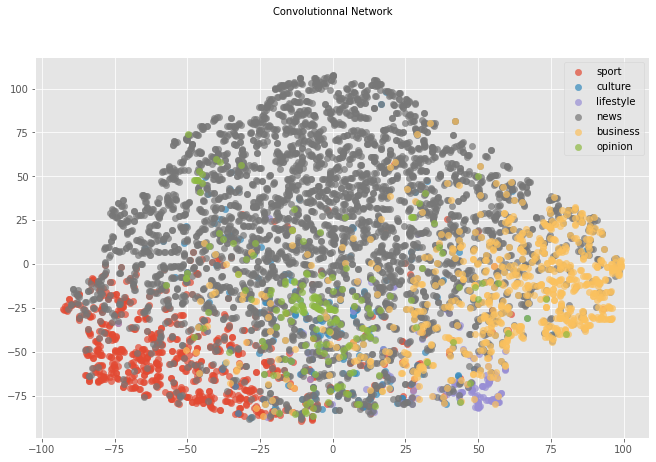

In [45]:
# _, x, _, y_ind = train_test_split(X_val, Y_val,
#                                 test_size=0.1, 
#                                 random_state=42,
#                                 stratify = Y_val)
from keras import backend as K
get_doc_embedding = K.function([model.layers[0].input, K.learning_phase()],
                                [model.layers[-2].output])
doc_embs = get_doc_embedding([x, 0])[0]
visualize_doc_embeddings(doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan'], 
                         y_ind, 'Convolutionnal Network')

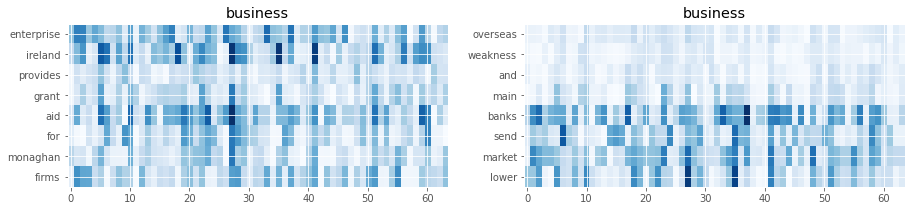

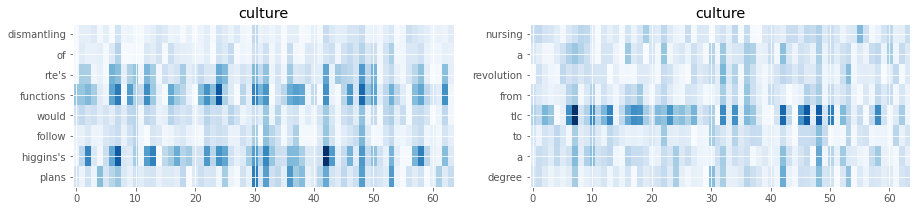

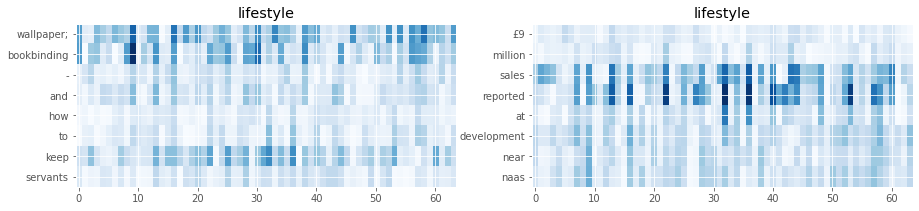

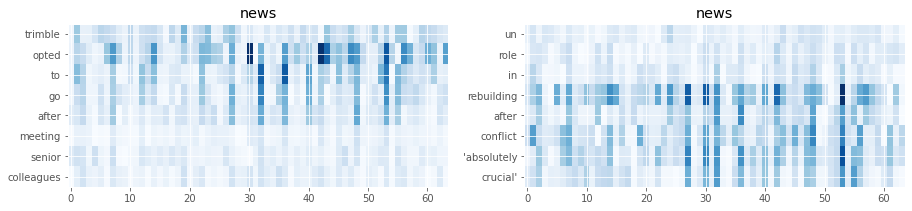

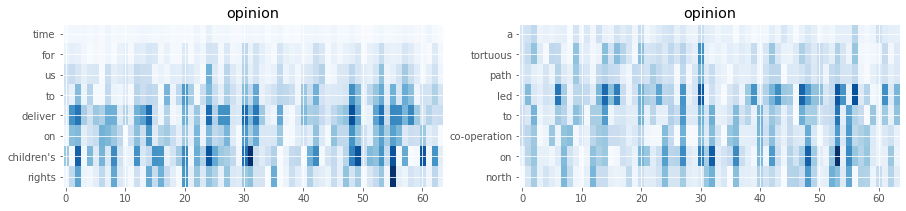

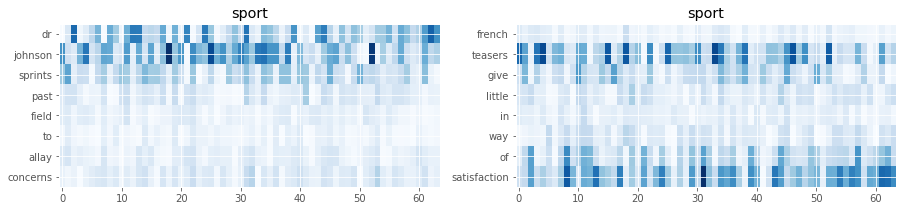

In [47]:
import warnings
warnings.simplefilter('ignore')
np.random.seed(0)
max_sent = 8
lenght = np.array([len(elt.split()) for elt in corpus_new])
for ind, element in enumerate(np.unique(Y_train)):
    index = np.random.choice(np.where((Y_train == element) & (lenght == max_sent))[0], 2)
    tokens = [corpus_new[i].split()[:max_sent] for i in index]
    tokens_ = X_train[index].reshape(2, maxlen)
#     y = Y_train[index]

    input_tensors = [model.layers[0].input, K.learning_phase()]
    saliency_input = model.layers[1].output ### fill the gap (extract the rows of the embedding matrix from the model) ###
    saliency_output = model.layers[-1].output[:, ind] ### fill the gap (get the probability distribution over classes from the model) ###

    gradients = model.optimizer.get_gradients(saliency_output, saliency_input)

    compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    matrix = compute_gradients([tokens_, 0])[0]
    ### fill the gap (compute the magnitude of the partial derivatives) ###
    ### you may use np.absolute https://docs.scipy.org/doc/numpy/reference/generated/numpy.absolute.html ###
    to_plot = np.absolute(matrix)

    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    for i in range(2):
        heatmap = ax[i].imshow(to_plot[i][:max_sent, :], cmap=plt.cm.Blues,interpolation='nearest', aspect='auto')
        ax[i].set_yticks(np.arange(len(tokens[i]))[:max_sent])
        ax[i].set_yticklabels(tokens[i][:max_sent])
        ax[i].tick_params(axis='y', which='major', labelsize=10 )
        ax[i].set_title(element)
#         ax[i].axis('off')
#     fig.colorbar(heatmap)
#     fig.set_size_inches(11,7)
    fig.savefig(element + '_saliency_map.png', bbox_inches='tight')
    fig.show()

# Bert

In [0]:
# import ktrain
# !pip3 install ktrain
import ktrain
from ktrain import text

In [12]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(X_train, Y_train, X_val, Y_val, 
                                                                      max_features= 80000, maxlen=10,
                                                                      preprocess_mode='bert', class_names=list(np.unique(Y_train)))
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, multilabel=True, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=512,
                             eval_batch_size=512, workers=2, use_multiprocessing=True)

task: text classification
preprocessing train...
language: en


preprocessing test...
language: en


Is Multi-Label? True
maxlen is 10
done.


In [13]:
hist = learner.fit_onecycle(2e-4, 1)



begin training using onecycle policy with max lr of 0.0002...
Train on 350000 samples, validate on 75000 samples
350000/350000 [==============================] - 1488s 4ms/sample - loss: 0.1813 - accuracy: 0.9244 - val_loss: 0.1421 - val_accuracy: 0.9417


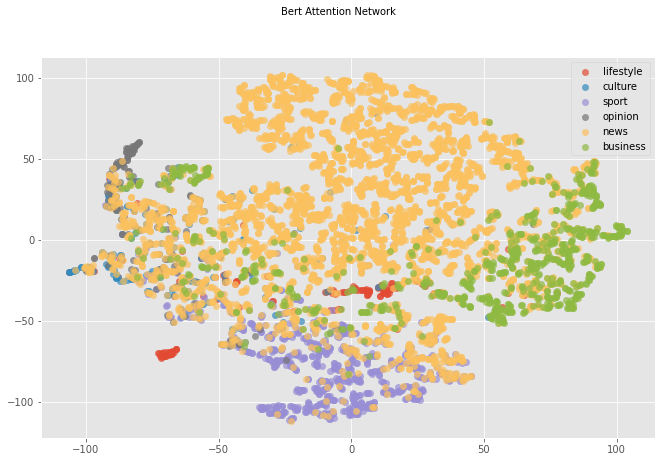

In [17]:
_, ind_x, _, y_ind = train_test_split(np.arange(len(X_val)), Y_val,
                                test_size=0.08, 
                                random_state=42,
                                stratify = Y_val)
get_doc_embedding = K.function([model.layers[0].input, model.layers[1].input, K.learning_phase()],
                                [model.layers[-2].output])
doc_embs = get_doc_embedding([x_test[0][ind_x], x_test[1][ind_x], 0])[0]
visualize_doc_embeddings(doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan'], 
                         y_ind, 'Bert Attention Network')

In [0]:
model.summary()

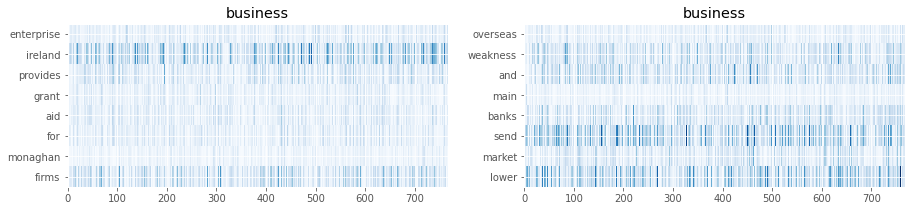

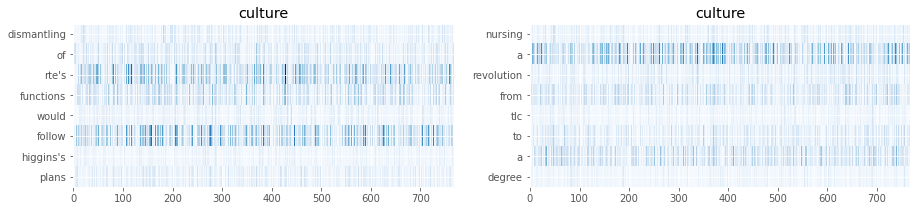

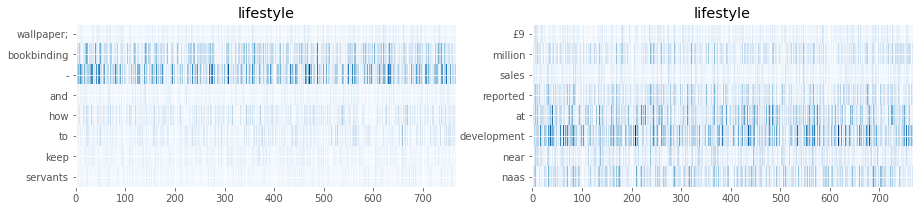

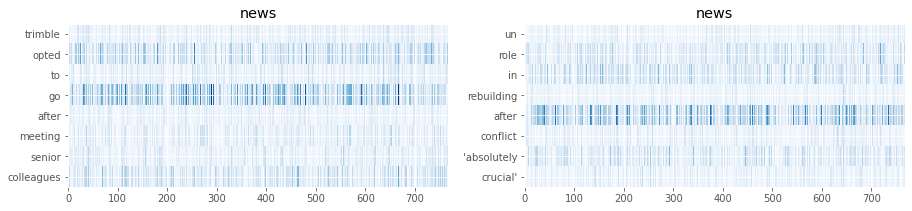

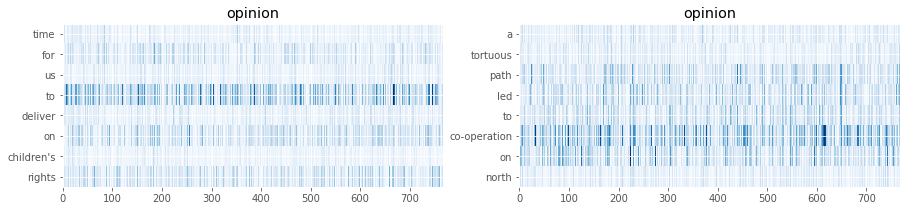

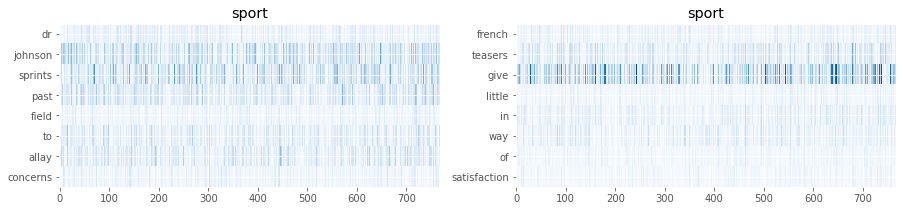

In [28]:
import warnings
warnings.simplefilter('ignore')
np.random.seed(0)
max_sent = 8
maxlen=10
lenght = np.array([len(elt.split()) for elt in corpus_new])
for ind, element in enumerate(np.unique(Y_train)):
    index = np.random.choice(np.where((Y_train == element) & (lenght == max_sent))[0], 2)
    tokens = [corpus_new[i].split()[:max_sent] for i in index]
    tokens_ = [x_train[0][index], x_train[1][index]]
    # tokens_ = X_train[index].reshape(2, maxlen)
#     y = Y_train[index]

    input_tensors = [model.layers[0].input, model.layers[1].input, K.learning_phase()]
    saliency_input = model.layers[3].output ### fill the gap (extract the rows of the embedding matrix from the model) ###
    saliency_output = model.layers[-1].output[:, ind] ### fill the gap (get the probability distribution over classes from the model) ###

    gradients = model.optimizer.get_gradients(saliency_output, saliency_input)

    compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    matrix = compute_gradients([tokens_, 0])[0]
    ### fill the gap (compute the magnitude of the partial derivatives) ###
    ### you may use np.absolute https://docs.scipy.org/doc/numpy/reference/generated/numpy.absolute.html ###
    to_plot = np.absolute(matrix)

    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    for i in range(2):
        heatmap = ax[i].imshow(to_plot[i][:max_sent, :], cmap=plt.cm.Blues,interpolation='nearest', aspect='auto')
        ax[i].set_yticks(np.arange(len(tokens[i]))[:max_sent])
        ax[i].set_yticklabels(tokens[i][:max_sent])
        ax[i].tick_params(axis='y', which='major', labelsize=10 )
        ax[i].set_title(element)
#         ax[i].axis('off')
#     fig.colorbar(heatmap)
#     fig.set_size_inches(11,7)
    # fig.savefig('BERT_other' + element + '_saliency_map.png', bbox_inches='tight')
    fig.show()